In [1]:
import sys
sys.path.append("..")

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import os
from os.path import exists

import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

config = {
    'figure.figsize':(14,4),
    'figure.constrained_layout.use':True,
    'figure.facecolor':'w',
    'axes.grid':True,
    'grid.linewidth':0.5,
    'grid.linestyle':'--',
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

SEED = sum(list(map(ord, 'climate_bayes')))
rng = np.random.default_rng(SEED)

In [2]:
from laos_gggi.combine_data import final_data

# Data

In [3]:
#Load data
data = final_data()
df_clim = data["df_time_series"][["co2", "Temp"]].iloc[1:-1] 
emdat_damage = data["emdat_damage"]["Total_Damage_Adjusted"]

In [4]:
#Fill NaN values
emdat_damage_filled = emdat_damage.fillna(0)

In [5]:
#Normalize climate data
df_clim_norm = (df_clim - df_clim.mean())/df_clim.std()

In [6]:
emdat_damage_filled = emdat_damage_filled.reset_index().set_index(["Start_Year"])

In [18]:
development_indicators = data["wb_data"]
development_indicators = development_indicators.reset_index().set_index(["Start_Year"])

In [27]:
emdat_damage_filled

,ISO,Total_Damage_Adjusted
Start_Year,,
1969,AFG,0.0
1970,AFG,0.0
1971,AFG,0.0
1972,AFG,0.0
1973,AFG,0.0
...,...,...
2020,ZWE,0.0
2021,ZWE,0.0
2021,ZWE,0.0


In [25]:
df = (pd.merge(emdat_damage_filled, df_clim_norm, right_index= True, left_index=True, how = "left")).reset_index().set_index(["ISO", "Start_Year"])

In [26]:
df

Total_Damage_Adjusted       co2      Temp
ISO Start_Year                                           
AFG 1969                          0.0 -1.112287 -0.898596
    1969                          0.0 -1.112287 -1.151821
    1969                          0.0 -1.112287 -1.094685
    1969                          0.0 -1.112287 -1.237305
    1970                          0.0 -1.078250 -1.494783
...                               ...       ...       ...
ZWE 2022                          0.0  1.903154  2.254379
    2023                          0.0  1.985034  2.278231
    2023                          0.0  1.985034  2.188516
    2023                          0.0  1.985034  2.217177
    2023                          0.0  1.985034  2.484690

[48664 rows x 3 columns]

In [7]:
#Integrate all the data sets
df = (pd.merge(emdat_damage_filled, df_clim_norm, right_index= True, left_index=True, how = "left")
           .reset_index().fillna(0))

df = (pd.merge(df, development_indicators, right_index= True, left_index=True, how = "left")
           .reset_index()

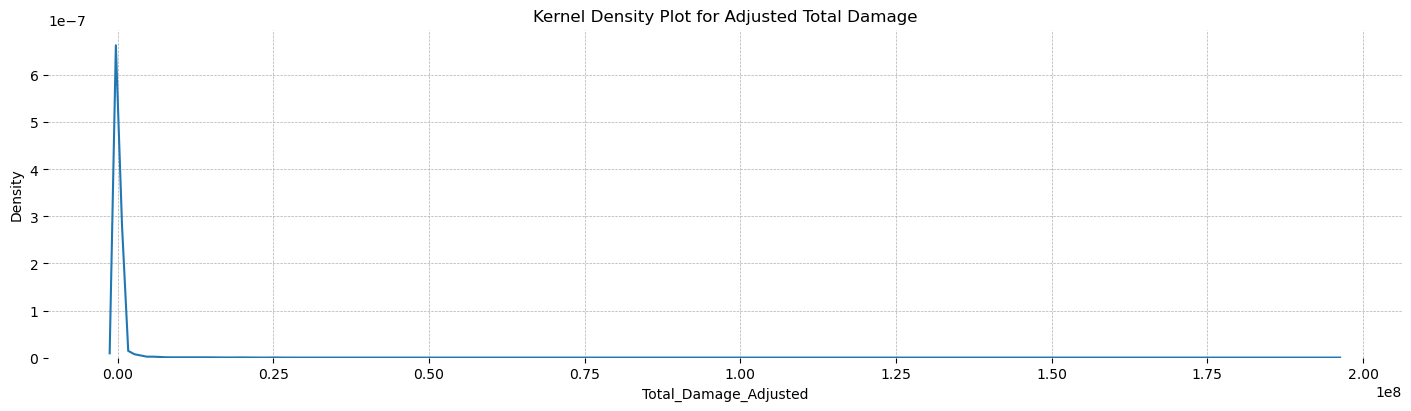

In [8]:
sns.kdeplot(emdat_damage_filled["Total_Damage_Adjusted"])
plt.title("Kernel Density Plot for Adjusted Total Damage") ;

# Model

In [37]:
#Set coordinates
ISO_idx, ISO =  pd.factorize(df_norm["ISO"])
obs_idx = df_norm.index

COORDS = {'ISO':ISO, 
          #'Year_vals':df['Start_Year'].cat.categories.values,
          "obs_idx": obs_idx}

In [83]:
with pm.Model(coords=COORDS) as damages_model:

    #Declare data
    damages = pm.Data("damages", df_norm["Total_Damage_Adjusted"]  , dims=["obs_idx"])
    co2 = pm.Data("co2", df_norm["co2"]  , dims=["obs_idx"])
    temp = pm.Data("temp", df_norm["Temp"]  , dims=["obs_idx"])

    #Country effect
    country_effect_mu = pm.Normal('country_effect_mu', mu = 0, sigma = 10)
    country_effect_scale = pm.Gamma('country_effect_scale', alpha=2, beta=1)
    country_effect_offset = pm.Normal('country_effect_offset', sigma=1, dims="ISO")
    country_effect = pm.Deterministic('country_effect', country_effect_mu + country_effect_scale * country_effect_offset, dims="ISO")

    #Development indicators: 

   # b2 = pm.Normal("Year", mu=0, sigma=1, dims="Year_vals")
    Ocean_temp_effect = pm.Normal("Ocean_temp_effect", mu=0, sigma=1)
    CO2_effect = pm.Normal("CO2_effect", mu=0, sigma=1)

#    year_data = pm.Data('year_data', df['Start_Year'].cat.codes.to_numpy(), dims="obs_idx")

    theta = (country_effect[ISO_idx]+ Ocean_temp_effect*temp + CO2_effect*co2)
    sigma = pm.Exponential("sigma", 1)

    # ## Define likelihood
    y_hat = pm.Normal("y_hat", mu= theta, sigma = sigma, observed=damages, dims = "obs_idx")

In [84]:
with damages_model:
    prior_idata = pm.sample_prior_predictive( )

prior_idata.prior_predictive =  prior_idata.prior_predictive.assign_coords({"obs_idx":obs_idx})

Sampling: [CO2_effect, Ocean_temp_effect, country_effect_mu, country_effect_offset, country_effect_scale, sigma, y_hat]


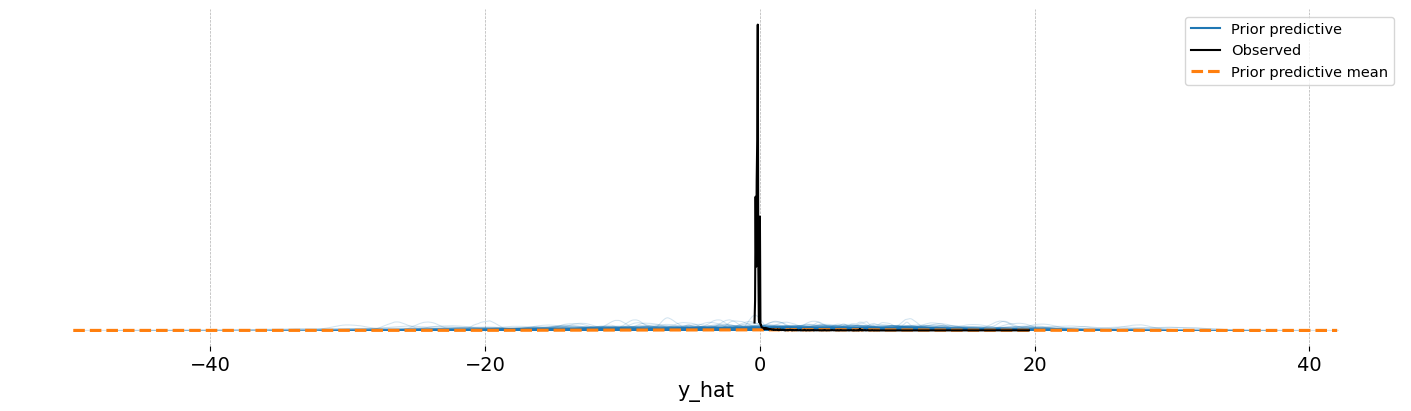

In [85]:
az.plot_ppc(prior_idata, group = "prior", observed = prior_idata.observed_data );

## Sampling

In [86]:
#Sampling
with damages_model:
    damages_idata = pm.sample(nuts_sampler='nutpie', chains=8, draws=1000)
    damages_idata = pm.sample_posterior_predictive(damages_idata, 
                                                predictions=True, 
                                                return_inferencedata=True, extend_inferencedata=True).assign_coords({"obs_idx":obs_idx})

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.38,15
,2000,0,0.40,7
,2000,0,0.40,7
,2000,0,0.39,15
,2000,0,0.39,15
,2000,0,0.40,15
,2000,0,0.41,15
,2000,0,0.43,7


Sampling: [y_hat]


Output()

# Diagnosis

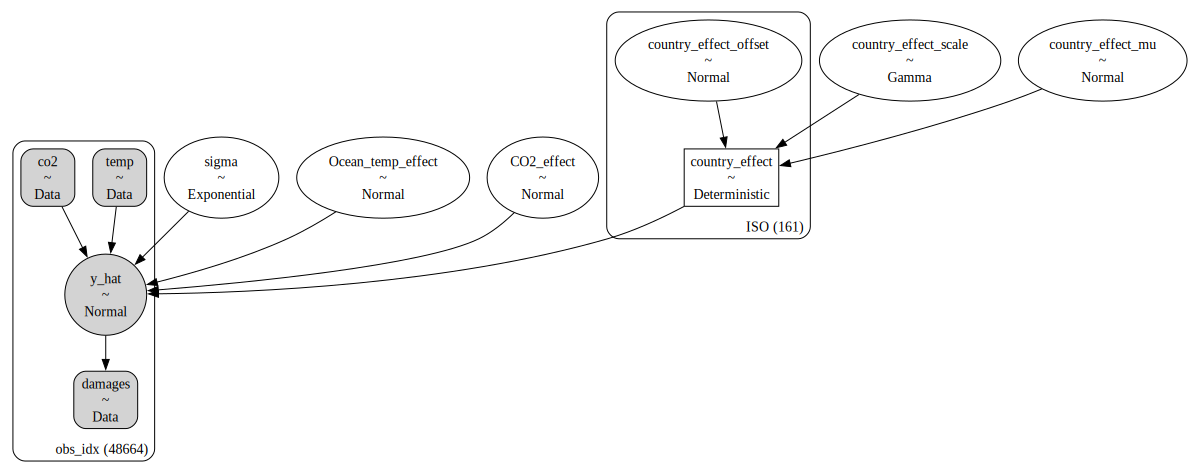

In [87]:
pm.model_to_graphviz(damages_model)

In [88]:
az.summary(
    damages_idata,
    var_names=["country_effect_mu", "country_effect_scale", "Ocean_temp_effect", "CO2_effect", "sigma"],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
country_effect_mu,-0.022,0.005,-0.031,-0.013,0.0,0.0,14791.0,5688.0,1.0
country_effect_scale,0.006,0.003,0.000,0.011,0.0,0.0,9592.0,4935.0,1.0
Ocean_temp_effect,-0.069,0.018,-0.104,-0.035,0.0,0.0,2486.0,3638.0,1.0
CO2_effect,0.124,0.020,0.087,0.162,0.0,0.0,2450.0,3303.0,1.0
sigma,0.946,0.003,0.940,0.952,0.0,0.0,14689.0,5900.0,1.0


C:\Users\camil\AppData\Local\Temp\ipykernel_156104\261543429.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


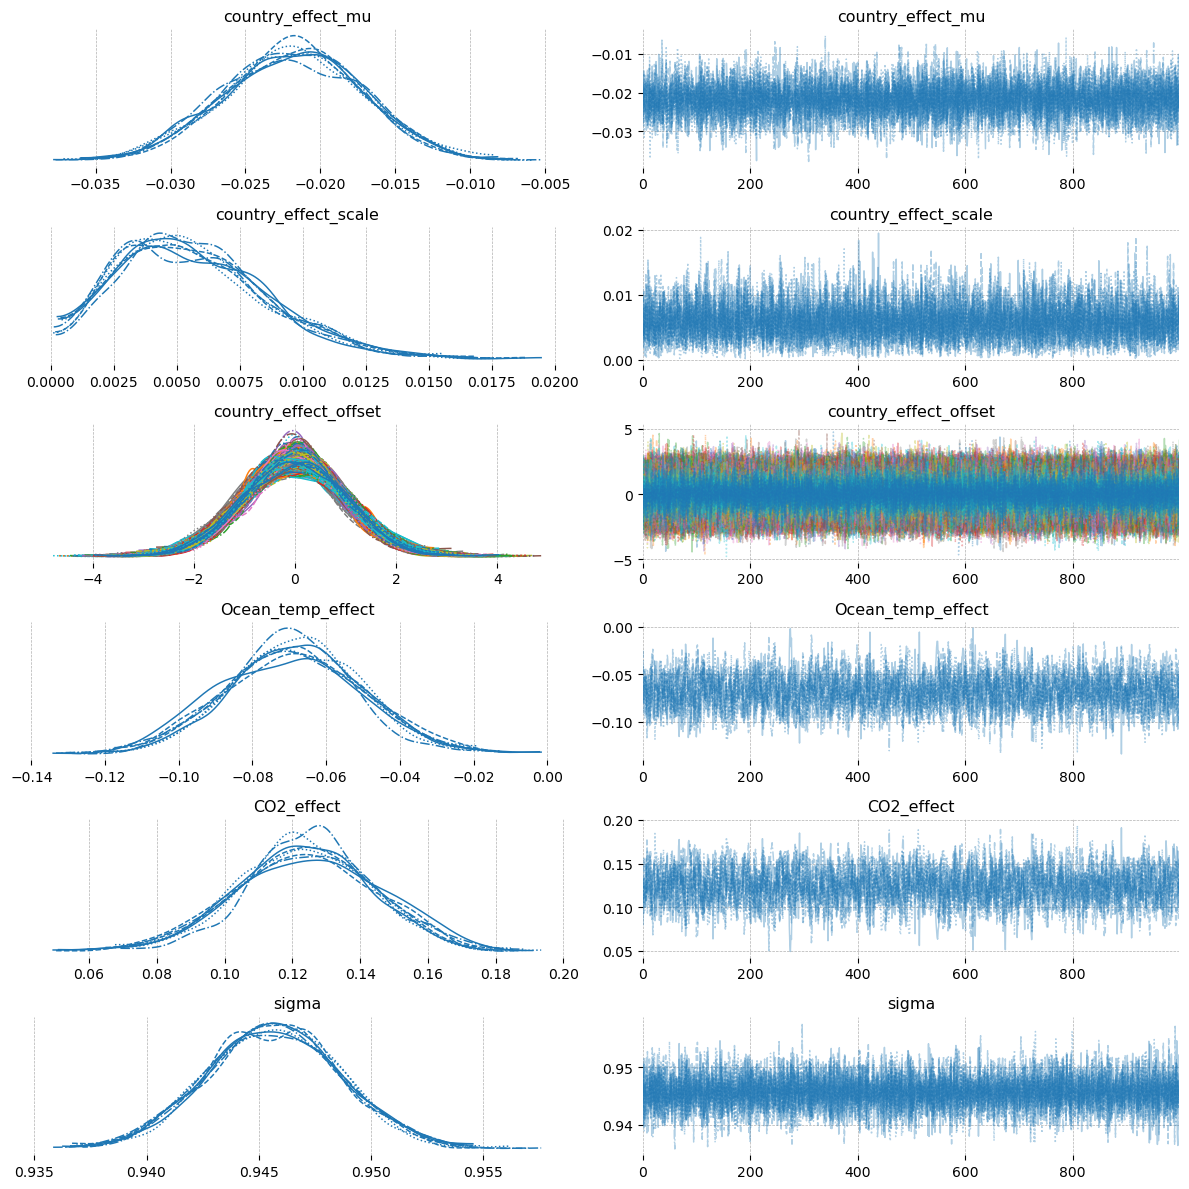

In [89]:
trace_vars = [rv.name for rv in damages_model.free_RVs]

az.plot_trace(damages_idata, var_names=trace_vars)
plt.tight_layout();

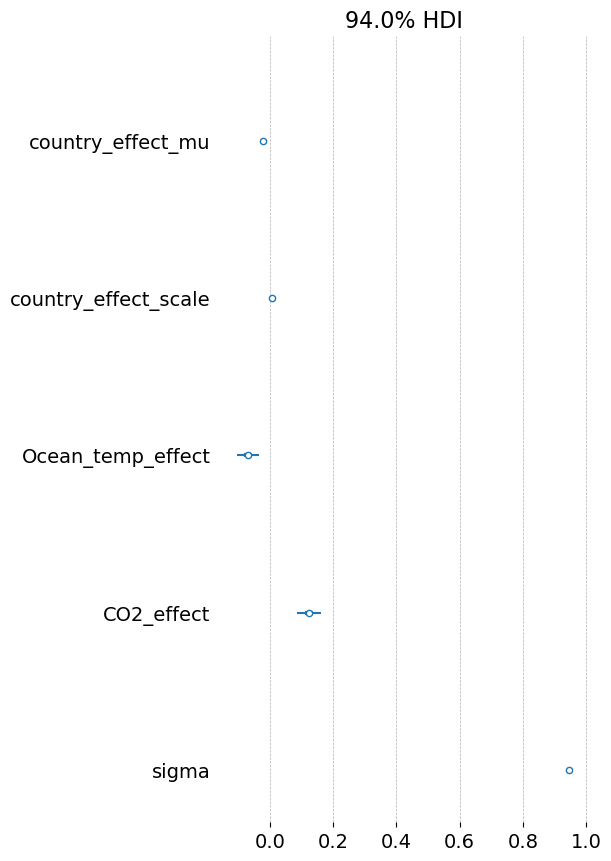

In [90]:
az.plot_forest(damages_idata, var_names = ["country_effect_mu", "country_effect_scale", "Ocean_temp_effect", "CO2_effect", "sigma"], combined= True);